In [2]:
import glob
import xarray as xr

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR 1: PROJ: proj_create_from_database: Open of /autofs/nccsopen-svm1_home/jrobrien/miniforge3/envs/sail-xprecip-dev/share/proj failed


In [3]:
DATE = "2025-03-05"
# Define the directory where the BNF CSAPR-2 CMAC files are located.
RADAR_DIR = "/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/"

In [27]:
# With the user defined RADAR_DIR, grab all the XPRECIPRADAR CMAC files for the defined DATE
file_list = sorted(glob.glob(RADAR_DIR + 'bnfcsapr2cmacS3.c1.' + DATE.replace('-', '') + '*.nc'))
file_list[:10]

['/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.000253.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.000311.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.001255.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.001313.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.002258.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.002316.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.003301.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.003319.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.004303.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.004321.nc']

In [5]:
ds = xr.open_dataset(file_list[10])

In [6]:
ds

<xarray.Dataset> Size: 28MB
Dimensions:                                                (time: 89,
                                                            range: 1100,
                                                            sweep: 15)
Coordinates:
  * time                                                   (time) datetime64[ns] 712B ...
  * range                                                  (range) float32 4kB ...
    azimuth                                                (time) float32 356B ...
    elevation                                              (time) float32 356B ...
Dimensions without coordinates: sweep
Data variables: (12/75)
    base_time                                              datetime64[ns] 8B ...
    time_offset                                            (time) datetime64[ns] 712B ...
    attenuation_corrected_differential_reflectivity        (time, range) float32 392kB ...
    attenuation_corrected_differential_reflectivity_lag_1  (time, range) float32 392kB ...
    attenuation_corrected_reflectivity_h                   (time, range) float32 392kB ...
    censor_mask                                            (time, range) int32 392kB ...
    ...                                                     ...
    time_coverage_end                                      |S22 22B ...
    time_reference                                         |S22 22B ...
    volume_number                                          int32 4B ...
    lat                                                    float32 4B ...
    lon                                                    float32 4B ...
    alt                                                    float32 4B ...
Attributes: (12/22)
    command_line:          cmaccsapr2 -s bnf -f S3 -b 20250305.000000 -e 2025...
    process_version:       vap-cmaccsapr2-0.0-0.dev0.dirty.el8
    dod_version:           csapr2cmac-c1-1.1
    input_datastreams:     bnfcsapr2cfrS3.a1 : 1.7 : 20250305.005306\nbnfsond...
    site_id:               bnf
    Conventions:           CF/Radial instrument_parameters ARM-1.3
    ...                    ...
    version:               2.0 lite
    vap_name:              cmac
    known_issues:          False phidp jumps in insect regions. Still uses ol...
    field_names:           attenuation_corrected_differential_reflectivity, a...
    source:                Atmospheric Radiation Measurement (ARM) program C-...
    history:               created by user rjackson on machine cirrus47.ccs.o...

In [7]:
ds.alt.data

array(180., dtype=float32)

In [8]:
ds.alt

<xarray.DataArray 'alt' ()> Size: 4B
array(180., dtype=float32)
Attributes:
    long_name:      Altitude above mean sea level
    units:          m
    standard_name:  altitude

In [9]:
radar = pyart.io.read(file_list[15])

In [10]:
radar

In [20]:
file_list[15]

'/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.011947.nc'

In [11]:
radar?

Type:        Radar
String form: <pyart.core.radar.Radar object at 0x7f5bdff52c60>
File:        ~/miniforge3/envs/sail-xprecip-dev/lib/python3.12/site-packages/pyart/core/radar.py
Docstring:  
A class for storing antenna coordinate radar data.

The structure of the Radar class is based on the CF/Radial Data file
format. Global attributes and variables (section 4.1 and 4.3) are
represented as a dictionary in the metadata attribute. Other required and
optional variables are represented as dictionaries in a attribute with the
same name as the variable in the CF/Radial standard. When a optional
attribute not present the attribute has a value of None. The data for a
given variable is stored in the dictionary under the 'data' key. Moment
field data is stored as a dictionary of dictionaries in the fields
attribute. Sub-convention variables are stored as a dictionary of
dictionaries under the meta_group attribute.

Refer to the attribute section for information on the parameters.

Attributes
--

In [12]:
radar.altitude['data'][0]

np.float32(12.0)

In [13]:
radar.azimuth["data"]

masked_array(data=[210.19592, 210.19592, 210.19592, 210.19592, 210.19592,
                   210.19592, 210.19592, 210.19592, 210.19592, 210.19592,
                   210.19592, 210.19592, 210.19592, 210.19592, 210.19592,
                   210.19592, 210.19592, 210.19592, 210.19592, 210.19592,
                   210.19592, 210.19592, 210.19592, 210.19592, 210.19592,
                   210.19592, 210.19592, 210.19592, 210.19592, 210.19592,
                   210.19592, 210.19592, 210.19592, 210.19592, 210.19592,
                   210.19592, 210.19592, 210.19592, 210.19592, 210.19592,
                   210.19592, 210.19592, 210.19592, 210.19592, 210.18494,
                   210.17395, 210.17395, 210.17395, 210.17395, 210.17395,
                   210.17395, 210.17395, 210.17395, 210.17395, 210.17395,
                   210.17395, 210.17395, 210.17395, 210.17395, 210.17395,
                   210.17395, 210.17395, 210.17395, 210.17395, 210.17395,
                   210.17395, 210.1739

In [14]:
    M1 = [34.34525, -87.33842]
    S4 = [34.46451,	-87.23598]
    S20 = [34.65401, -87.29264]
    S30	= [34.38501, -86.92757]
    S40	= [34.17932, -87.45349]

    sites = ["M1", "S4", "S20", "S30", "S40"]

    # Zip these together!
    lats, lons = list(zip(M1,
                          S4,
                          S20,
                          S30,
                          S40))

In [15]:
lats

(34.34525, 34.46451, 34.65401, 34.38501, 34.17932)

In [16]:
lons

(-87.33842, -87.23598, -87.29264, -86.92757, -87.45349)

In [17]:
da = (pyart.util.columnsect.column_vertical_profile(radar, lats[0], lons[0]).interp(height=np.arange(radar.altitude['data'][0], 10050, 50)))

in columnsect slice(np.int32(0), np.int32(89), None)
in columnsect slice(masked, masked, None)


/ccsopen/home/jrobrien/miniforge3/envs/sail-xprecip-dev/lib/python3.12/site-packages/numpy/ma/core.py:5384: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/ccsopen/home/jrobrien/miniforge3/envs/sail-xprecip-dev/lib/python3.12/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


TypeError: only integer scalar arrays can be converted to a scalar index

In [18]:
radar.sweep_start_ray_index

{'long_name': 'Index of first ray in sweep',
 'units': '1',
 '_FillValue': np.int32(-9999),
 'data': masked_array(data=[0, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --],
              mask=[False,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True],
        fill_value=-9999,
             dtype=int32)}

In [19]:
radar.sweep_end_ray_index

{'long_name': 'Index of last ray in sweep',
 'units': '1',
 '_FillValue': np.int32(-9999),
 'data': masked_array(data=[88, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --],
              mask=[False,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True],
        fill_value=-9999,
             dtype=int32)}

rhi


/ccsopen/home/jrobrien/miniforge3/envs/sail-xprecip-dev/lib/python3.12/site-packages/pyart/graph/radarmapdisplay.py:317: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(


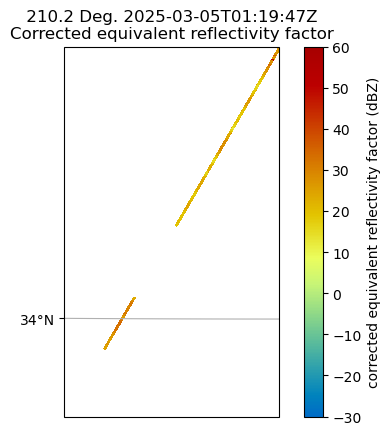

In [26]:
import numpy as np
radar.sweep_start_ray_index["data"] = np.ma.array([0])
radar.sweep_end_ray_index["data"] = np.ma.array([radar.nrays])
print(radar.scan_type)
# Create the Radar Map Display (defines x,y as lat/lons)
display = pyart.graph.RadarMapDisplay(radar)

# Display the horizontal equivalent reflectivity factor
# Note: embellish = False will remove initial lat/lon coords
display.plot_ppi_map(
    "corrected_reflectivity",
    0,
    vmin=-30,
    vmax=60,
    embellish=False,
    norm=None,
    cmap="HomeyerRainbow",
)


In [28]:
radar = pyart.io.read('/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.011947.nc')

In [30]:
radar.sweep_end_ray_index["data"]

masked_array(data=[88, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --],
             mask=[False,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True],
       fill_value=-9999,
            dtype=int32)

In [31]:
file_list

['/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.000253.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.000311.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.001255.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.001313.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.002258.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.002316.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.003301.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.003319.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.004303.nc',
 '/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.004321.nc',


In [32]:
radar = pyart.io.read('/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.010326.nc')

In [34]:
radar.sweep_start_ray_index

{'long_name': 'Index of first ray in sweep',
 'units': '1',
 '_FillValue': np.int32(-9999),
 'data': masked_array(data=[0, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --],
              mask=[False,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True],
        fill_value=-9999,
             dtype=int32)}

In [38]:
np.ma.is_masked(radar.sweep_start_ray_index["data"][1:])

True

In [39]:
len(file_list)

274

In [42]:
j = 0
for i in range(25, 150, 25):
    print(i)
    for scan in file_list[j:i]:
        print(scan)

25
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.000253.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.000311.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.001255.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.001313.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.002258.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.002316.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.003301.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.003319.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.004303.nc
/gpfs/wolf2/arm/atm124/proj-shared/bnf/bnfcsapr2cmacS3.c1/bnfcsapr2cmacS3.c1.20250305.004321.nc
/gpfs/wolf2/arm/atm124/proj-shared/bn